# Cartilage VAE

This script illustrates the application of VAE in clustering cellular data as described in the paper.


In [5]:
# add parent folder path where lib folder is
path = r'K:\cartilageVAE'
import sys; sys.path.insert(0, path) 

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
import torch
import scipy.io as sio
import random
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1 import ImageGrid
from loaders import cell_data_loaders
from scipy import signal
import pickle
import tqdm
import scipy.stats as stats
from statsmodels.tsa.seasonal import STL
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# Load cell data 

In [6]:
# Cartilage data
expr_date = ['22_04_28','22_04_29','22_04_21']

'''
Load cell data
'''
loc_x = {}
loc_y = {}
im_loc_x = {}
im_loc_y = {}
impact_intensity = {}
cell = {}
for expr in expr_date :
    # location of cells 
    location=r'all_locs.mat'
    locs=sio.loadmat(os.path.join(path,expr,location))['all_locs']
    loc_x[expr] =locs[:,0]
    loc_y[expr] =locs[:,1]
    
    # load cell data 
    file_name_r=r'red_all.mat'
    file_name_g=r'green_all.mat'
    file_name_b=r'blue_all.mat'
    R=sio.loadmat(os.path.join(path,expr,file_name_r))['red_all']
    G=sio.loadmat(os.path.join(path,expr,file_name_g))['green_all']
    B=sio.loadmat(os.path.join(path,expr,file_name_b))['blue_all']
    R = signal.resample(R,750).T
    G = signal.resample(G,750).T
    B = signal.resample(B,750).T
    N = R.shape[0]
    L = R.shape[1]
    cell[expr] = np.zeros((N,3,L))
    for i in range(N):
        cell[expr][i,0,:] = R[i,:]
        cell[expr][i,1,:] = G[i,:]
        cell[expr][i,2,:] = B[i,:]

    #load impact intensity
    
    impact_location=r'impact_locs.mat'
    im_locs=sio.loadmat(os.path.join(path,expr,impact_location))['impact_locs']
    im_loc_x[expr]=im_locs[:,0]
    im_loc_y[expr]=im_locs[:,1]
    
    impact_name = r'impact_intensity'
    impact_intensity[expr] = sio.loadmat(os.path.join(path,expr,impact_name))['impact_intensity']
    impact_intensity[expr] = signal.resample(impact_intensity[expr],750).T


In [7]:
# cell indices 
cell_date_ind = np.cumsum([0,7726,8713,7664])
impact_date_ind = np.cumsum([0,1175, 1871, 1632])

# load cell data and impact data into loaders for training 
cell_all = np.concatenate([cell[expr] for expr in expr_date],0)
cell_all = torch.Tensor(cell_all)

impact_all = np.concatenate([impact_intensity[expr] for expr in expr_date],0)
impact_all = torch.Tensor(impact_all)

cell_loaders=cell_data_loaders(cell_all,split=0.8,batch_size=32, shuffle=True, num_workers=0)


# VAE training

In [154]:
import encoders, decoders

cell_latent = 32
# encoder to cell response 
encoder_cell= encoders.Conv1DEncoder(n_latent =cell_latent,n_channel =3)
decoder_cell= decoders.Conv1DDecoder(n_latent =cell_latent,n_channel =3)

from wrapper import CONV1D_VAE
random.seed(1886)
model_cell = CONV1D_VAE(encoder_cell,decoder_cell,latent_dim =2 ,lr =1e-3,save_dir=r'F:\vae_jy\10July')
#model_cell.train_loop(cell_loaders,test_freq=20, epochs=101)
# save trained network 
#torch.save(model_cell.state_dict(), os.path.join(r'F:\vae_jy\10July\model_weights_normal_data_only.p'))

## load trained vae
model_cell.load_state_dict(torch.load(r'K:\cartilage_project\March28\model_weights.p'))
# have the network in evalution mode 
model_cell.eval()

CONV1D_VAE(
  (encoder): Conv1DEncoder(
    (conv1): Conv1d(3, 4, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(4, 8, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(8, 16, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=1504, out_features=256, bias=True)
    (fc21): Linear(in_features=256, out_features=128, bias=True)
    (fc23): Linear(in_features=256, out_features=128, bias=True)
    (fc31): Linear(in_features=128, out_features=32, bias=True)
    (fc33): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Conv1DDecoder(
    (fc4): Linear(in_features=32, out_features=128, bias=True)
    (fc5): Linear(in_features=128, out_features=256, bias=

# VAE analysis

In [155]:
'''
Get the latent representation and reconstructed cell profiles 
'''
loaders_cell=cell_data_loaders(cell_all,split=1,batch_size=100, shuffle=False, num_workers=4)
loaders_cell['test']=loaders_cell['train']

for i, data in enumerate(loaders_cell['train']):
    if i!=0:
        ori_cell=np.concatenate((ori_cell,data.cpu().squeeze().numpy()),axis=0)
    else:
        print()
        ori_cell=data.cpu().squeeze().numpy()
    data = data.to('cuda')
    with torch.no_grad():
        loss,mu,d,x_rec = model_cell.forward(data)
        if i!=0:
            recon_cell=np.concatenate((recon_cell,x_rec.cpu().squeeze().numpy()),axis=0)
            latent_m_cell=np.concatenate((latent_m_cell,mu.cpu().squeeze().numpy()),axis=0)
            latent_d_cell=np.concatenate((latent_d_cell,d.cpu().squeeze().numpy()),axis=0)
        else:
            recon_cell=x_rec.cpu().squeeze().numpy()
            latent_m_cell=mu.cpu().squeeze().numpy()
            latent_d_cell=d.cpu().squeeze().numpy()

   

## Check the reconstructed cell profile

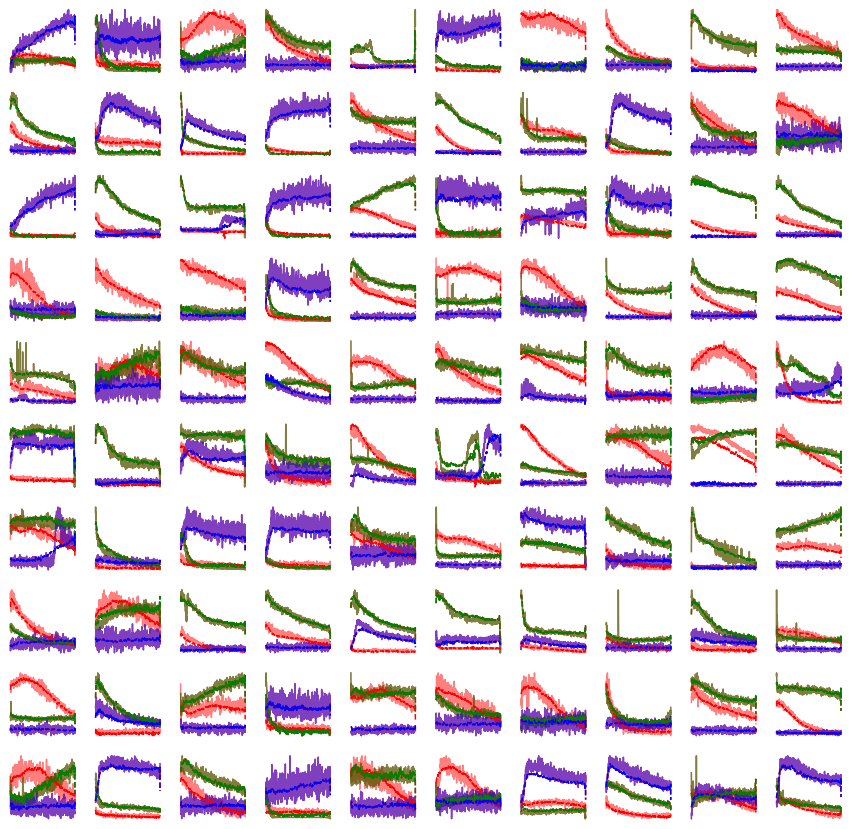

In [156]:

plt.figure(figsize=(15,15))

for i in range(100):
    plt.subplot(10,10,i+1)
    ii=random.randint(0,len(loaders_cell['train'].dataset))
    plt.plot(ori_cell[ii,:].squeeze().T,'r',alpha=0.5)
    plt.plot(ori_cell[ii,1,:].squeeze().T,'g',alpha=0.5)
    plt.plot(ori_cell[ii,2,:].squeeze().T,'b',alpha=0.5)
    plt.plot(recon_cell[ii,:].squeeze().T,'r--')
    plt.plot(recon_cell[ii,1,:].squeeze().T,'g--')
    plt.plot(recon_cell[ii,2,:].squeeze().T,'b--')
    plt.axis('off')    


## Reconstruction error distribution

In [157]:
'''
separate timescale with STL algorithm
'''

transient_cell = ori_cell.copy()
smooth_cell = ori_cell.copy()

recon_transient = recon_cell.copy()
recon_smooth = recon_cell.copy()

# period of 35 is sufficient to separate the calcium transient...
for i in tqdm.tqdm(range(ori_cell.shape[0])):
    for j in range(3):
        stl = STL(ori_cell[i,j,:].flatten()/255,period=35)
        res = stl.fit()
        smooth_cell[i,j,:] = res.trend
        transient_cell[i,j,:] = res.seasonal
        
        stl = STL(recon_cell[i,j,:].flatten()/255,period=35)
        res = stl.fit()
        recon_smooth[i,j,:] = res.trend
        recon_transient[i,j,:] = res.seasonal



100%|██████████████████████████████████████████████████████████████████████████| 24103/24103 [1:58:31<00:00,  3.39it/s]


# Check the reconstruction error distribution

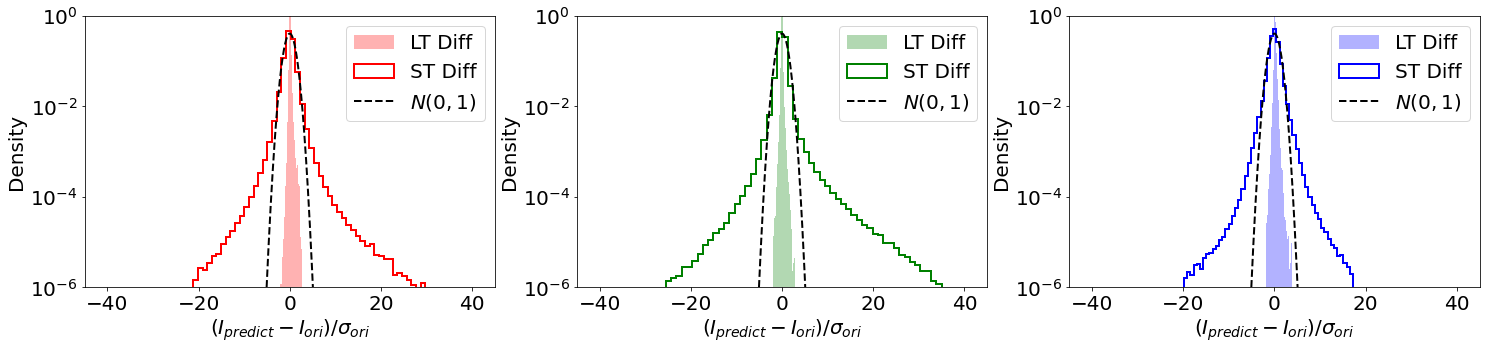

In [162]:
# check the error distribution for both long and short timescale 

y = np.linspace(-20, 20, 1000)

plt.rcParams['font.size'] = '20'
cols = ['r','g','b']

plt.figure(figsize=(25,5))

for i in range(3):
    
    plt.subplot(1,3,1+i)
    LT_diff = smooth_cell[:,i,:].flatten()/255-recon_smooth[:,i,:].flatten()/255
    ST_diff = transient_cell[:,i,:].flatten()/255-recon_transient[:,i,:].flatten()/255
    std_long_time = np.std(smooth_cell[:,i,:].flatten()/255)
    std_short_time = np.std(transient_cell[:,i,:].flatten()/255)
    
    plt.hist((LT_diff)/std_long_time,alpha = 0.3,bins = 100,density=True,log = True,color=cols[i], label ='LT Diff')
    plt.hist((ST_diff)/std_short_time,alpha = 1,bins = 100,density=True,log = True,color=cols[i],histtype='step', label ='ST Diff',linewidth=2)
    plt.plot(y, stats.norm.pdf(y,scale=1),'k--',linewidth=2,label='$N(0,1)$')
    
    plt.ylabel('Density')
    plt.xlabel('$(I_{predict}-I_{ori})/\sigma_{ori}$')
    plt.axis([-45,45,10e-7,1])
    plt.legend()
    

## Principal Component Analysis (PCA)

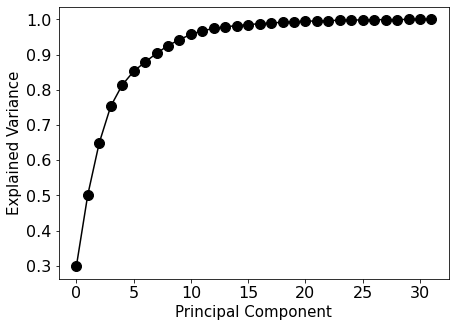

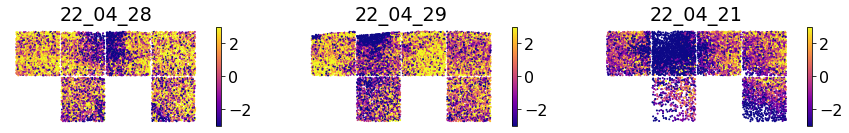

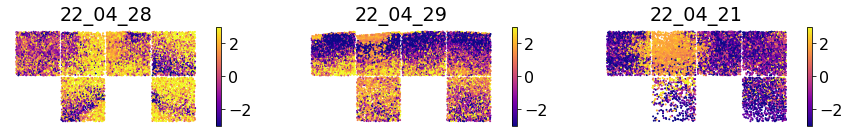

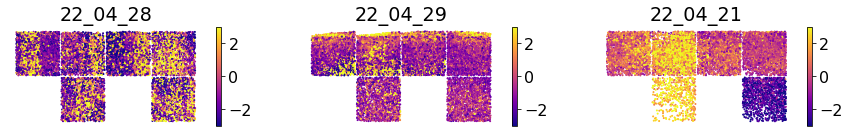

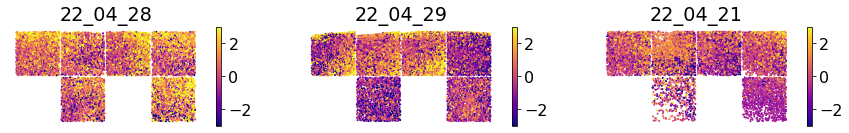

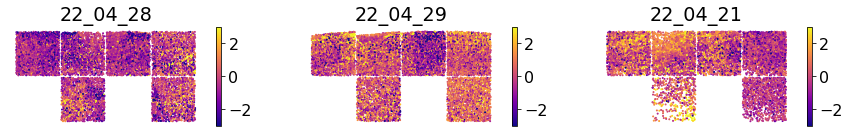

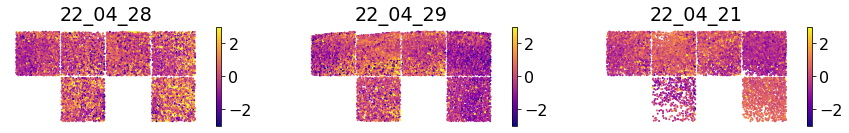

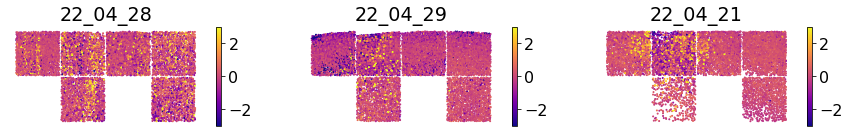

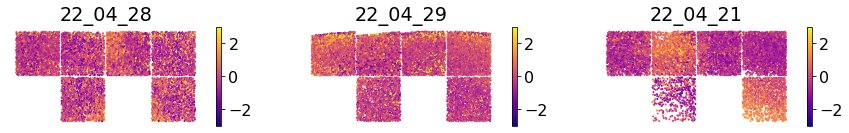

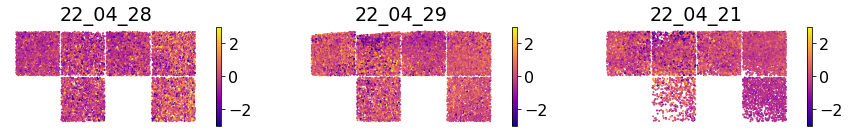

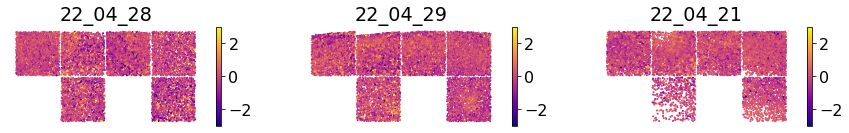

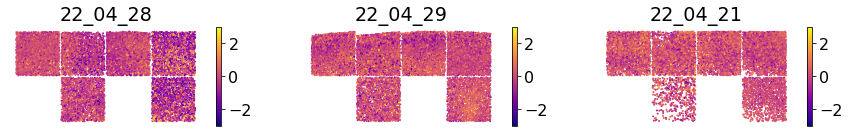

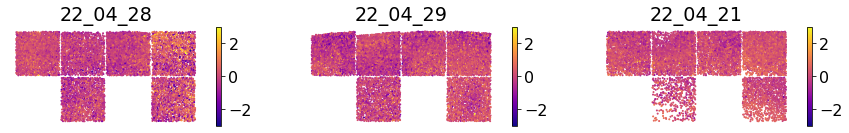

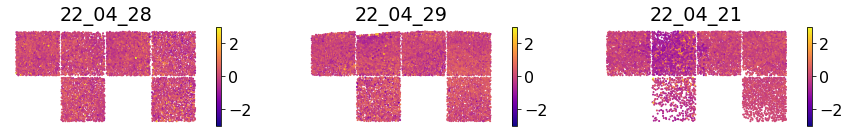

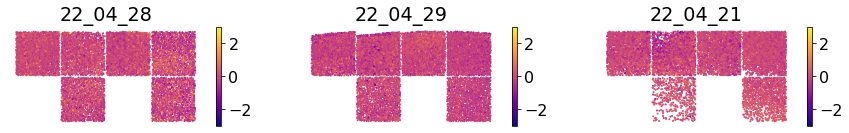

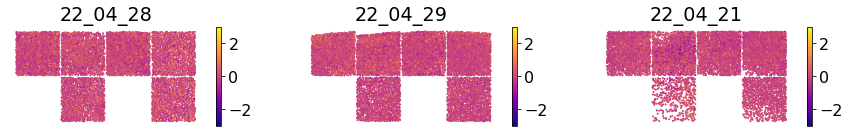

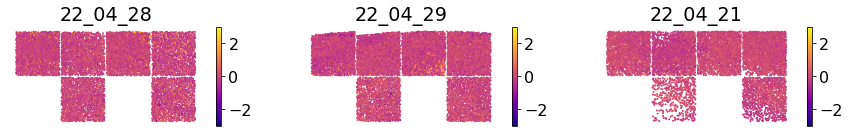

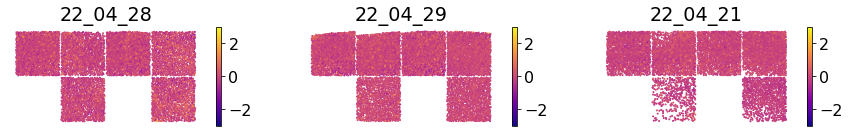

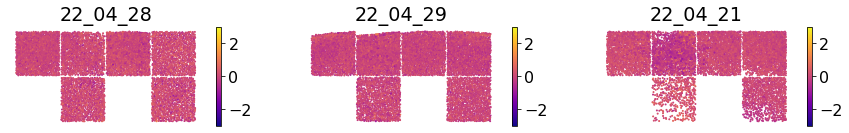

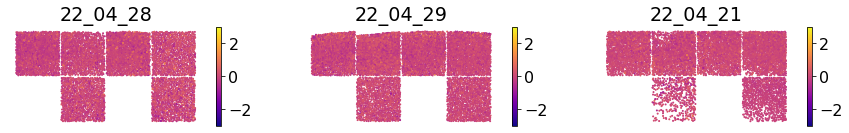

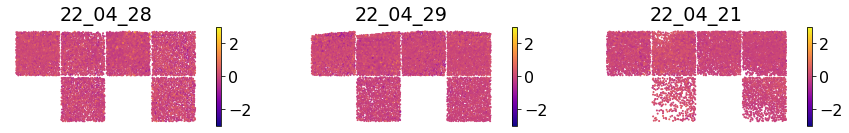

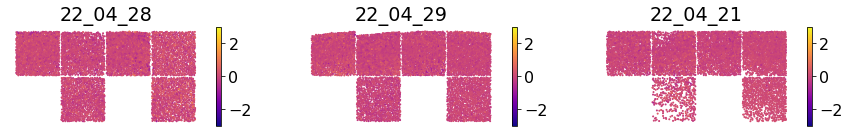

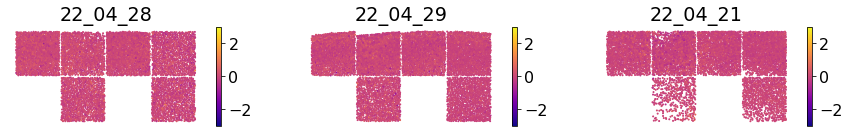

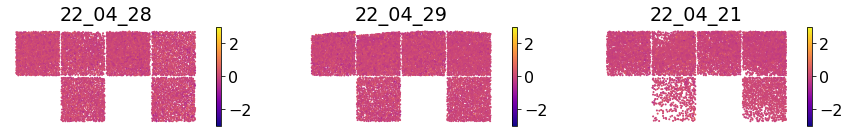

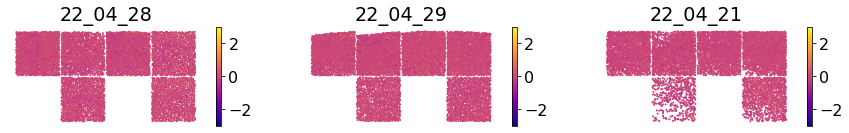

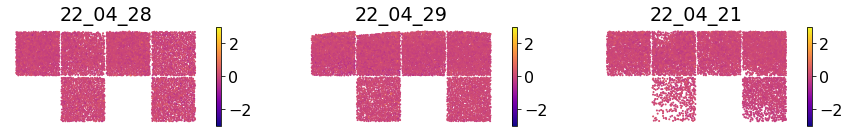

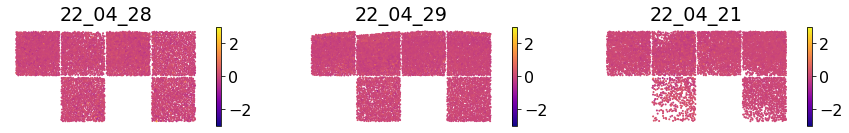

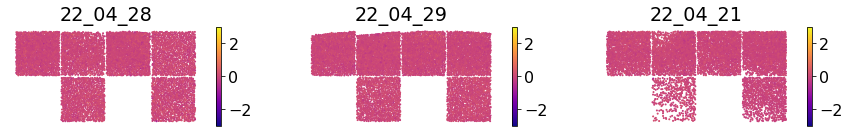

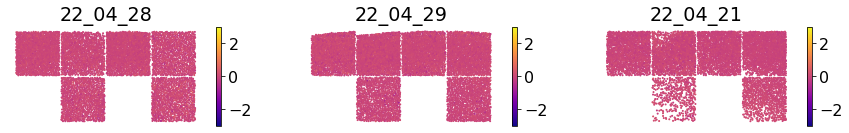

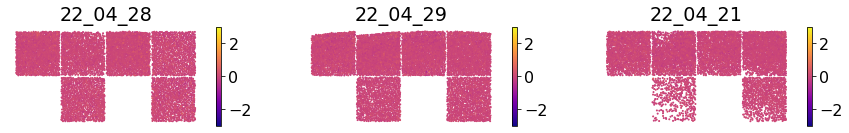

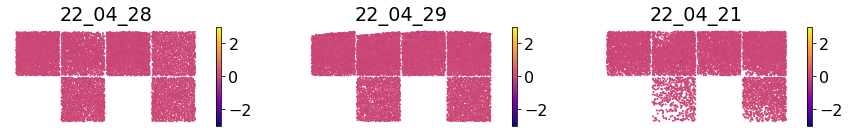

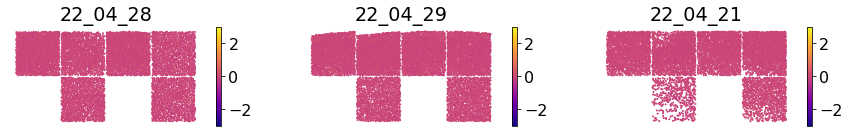

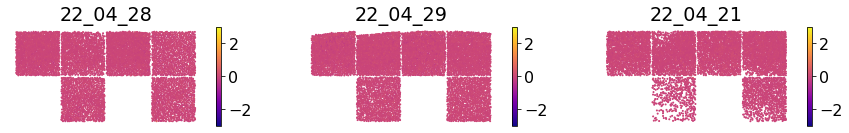

In [24]:
pca = PCA()
pca.fit(latent_m_cell)
plt.figure(figsize=(7,5))
plt.rcParams['font.size'] = '16'
plt.plot(np.arange(32),np.cumsum(pca.explained_variance_ratio_),'ko-',markersize=10) 
plt.ylabel('Explained Variance',fontsize=15)
plt.xlabel('Principal Component',fontsize=15)

'''
PC heatmap plot
'''
loc_x_all = np.concatenate([loc_x[expr] for expr in expr_date],0)
loc_y_all = np.concatenate([loc_y[expr] for expr in expr_date],0)
loc_x['22_04_28'].shape
import warnings
warnings.filterwarnings("ignore")

for i in range(32):
    plt.figure(figsize=(15,4))
    for m in range(3):
        plt.subplot(2,3,m+1)
        plt.scatter(loc_x_all[cell_date_ind[m]:cell_date_ind[m+1]],max(loc_y_all[cell_date_ind[m]:cell_date_ind[m+1]])-loc_y_all[cell_date_ind[m]:cell_date_ind[m+1]],c=pca.transform(latent_m_cell)[cell_date_ind[m]:cell_date_ind[m+1],i],cmap='plasma',s=1)
        plt.clim([-3,3])
        plt.colorbar()
        plt.axis('off')  
        plt.title(expr_date[m])
    

# Eigencurve analysis 

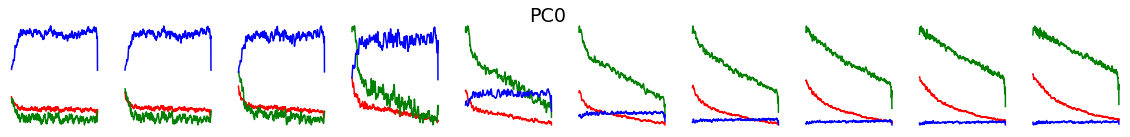

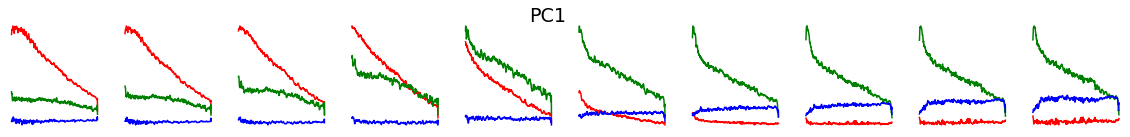

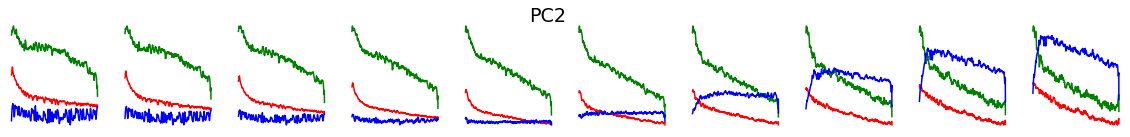

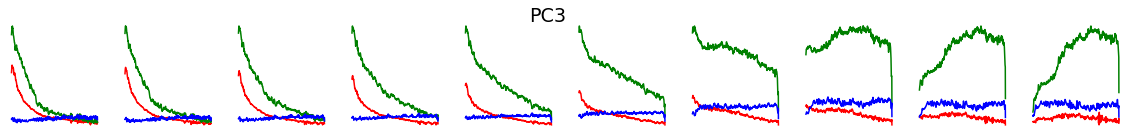

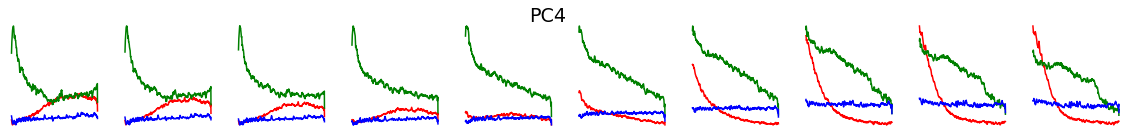

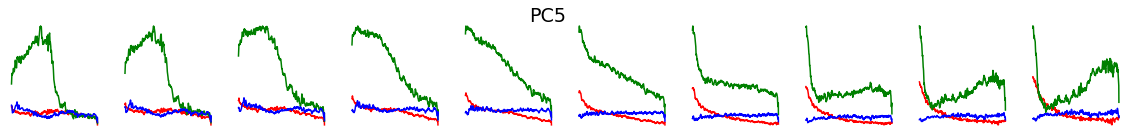

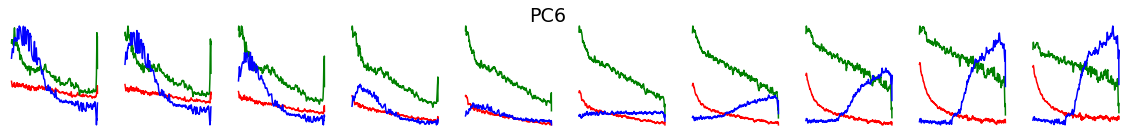

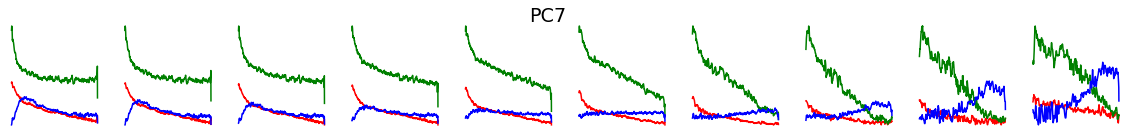

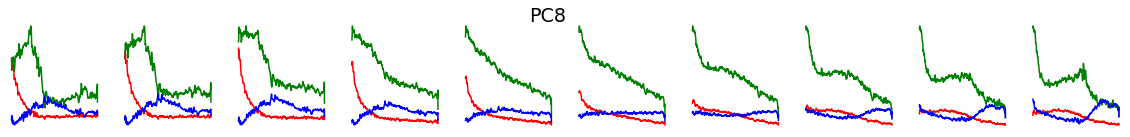

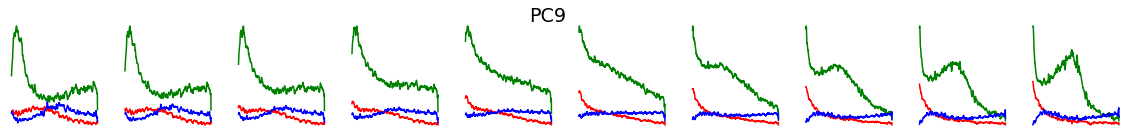

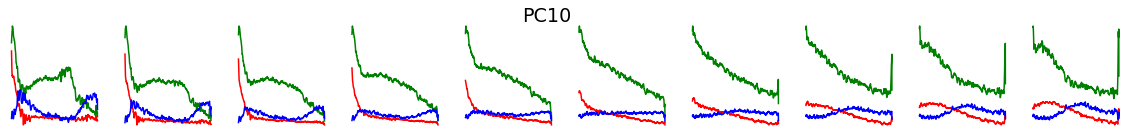

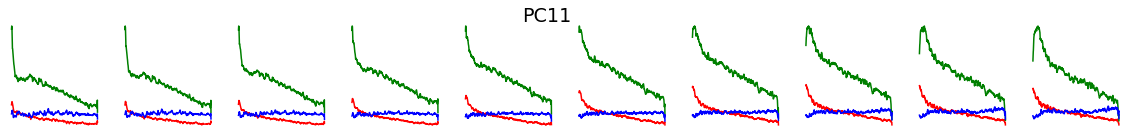

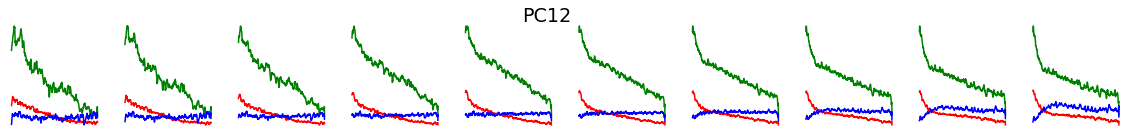

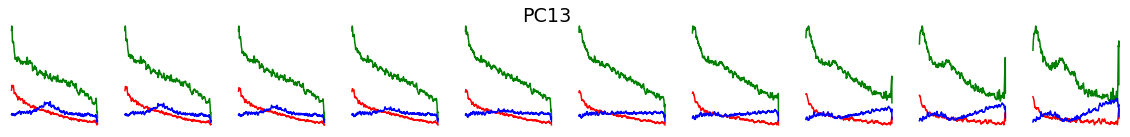

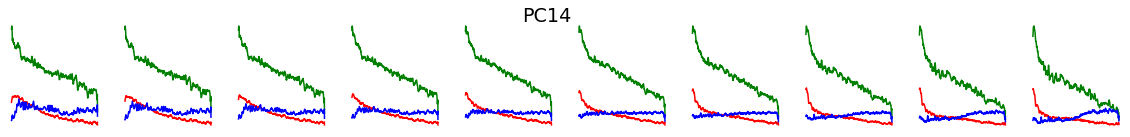

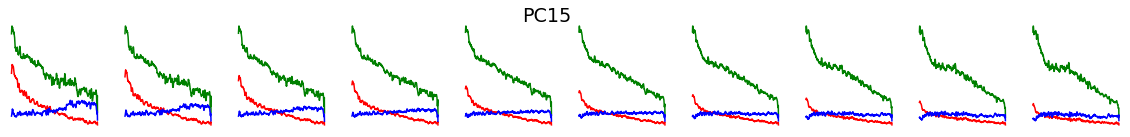

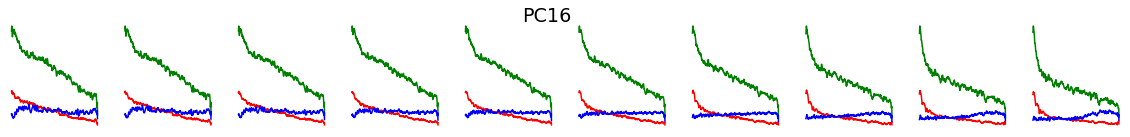

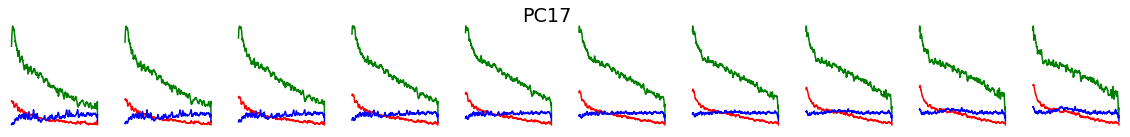

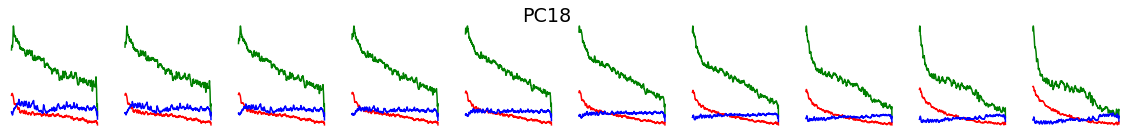

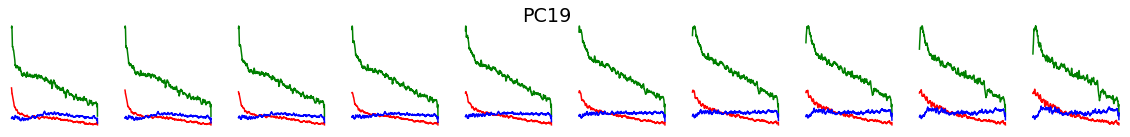

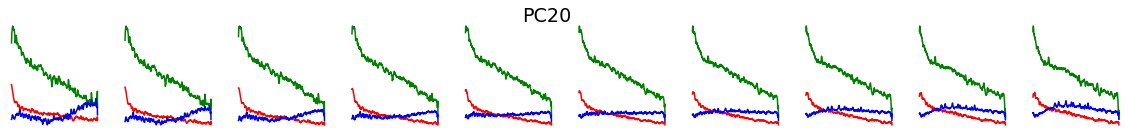

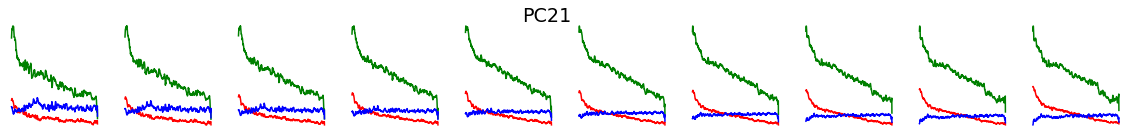

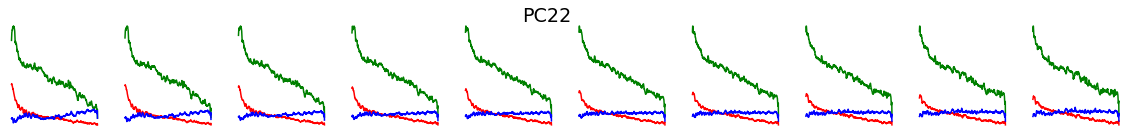

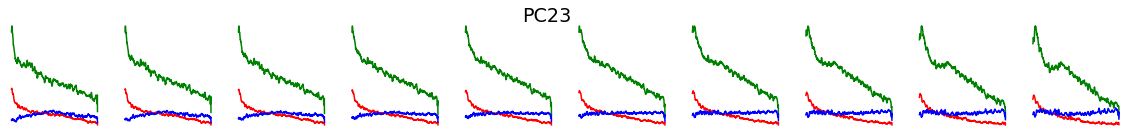

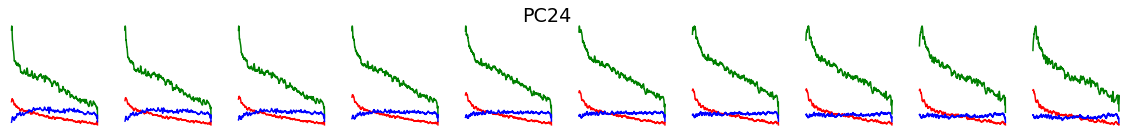

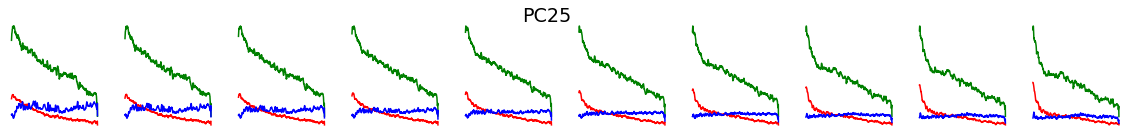

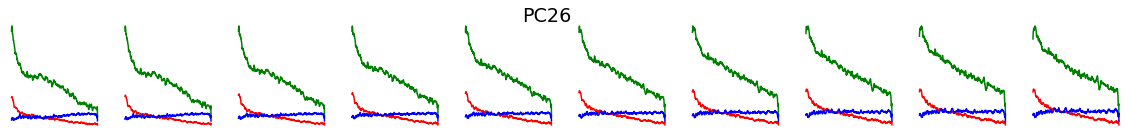

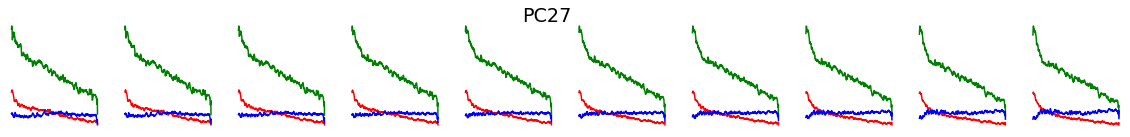

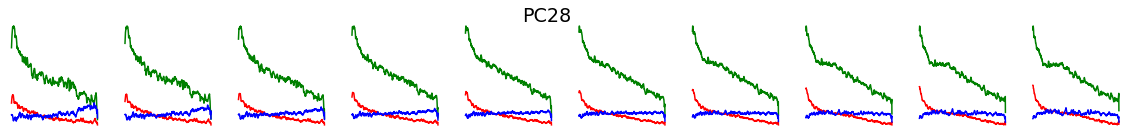

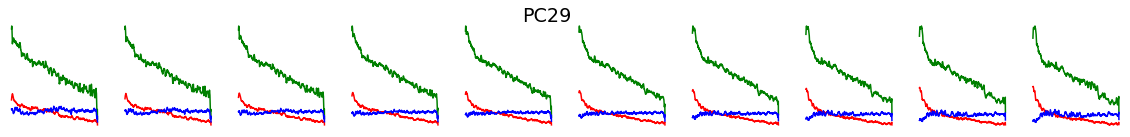

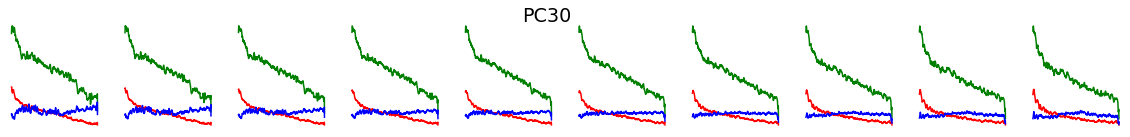

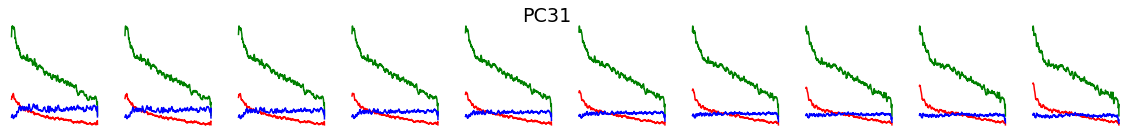

In [25]:

W=pca.components_
for n in range(32):
    z_grid = W[n,:].repeat(10).reshape([-1,10])
    for k in range(10):
        z_grid[:,k] =1*(k-5)*z_grid[:,k]
    with torch.no_grad():
        latent_var=model_cell.decoder(torch.Tensor(z_grid.T).to('cuda')).detach().cpu().numpy()
    plt.figure(figsize=(20,2))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.plot(latent_var[i,0,:].squeeze().T,'r')
        plt.plot(latent_var[i,1,:].squeeze().T,'g')
        plt.plot(latent_var[i,2,:].squeeze().T,'b')
        plt.axis('off')
    plt.suptitle('PC'+str(n))




# Compute the symmetrized KL divergence between latent distributions 

In [26]:

def SymKL(mu1,u1,d1,mu2,u2,d2):
    eta1,phi1 = natural_param(mu1,u1,d1)
    eta2,phi2 = natural_param(mu2,u2,d2)
    
    return np.matmul(phi1[0]-phi2[0],eta1[0]-eta2[0])+np.trace(np.matmul(phi1[1]-phi2[1],eta1[1]-eta2[1]))

def natural_param(mu,u,d):
    Sigma = np.outer(u,u)+np.diag(d)
    inv_Sigma = np.linalg.inv(Sigma)
    
    eta1=np.matmul(inv_Sigma,mu)
    eta2 = -inv_Sigma/2
    phi1 = np.array(mu)
    phi2 = np.outer(mu,mu)+Sigma
    eta =[eta1,eta2]
    phi =[phi1,phi2]
    return eta,phi

In [ ]:

for m in range(3):
    N=latent_m_cell[cell_date_ind[m]:cell_date_ind[m+1]].shape[0]
    print(N)
    D=np.zeros((N,N))
    
    cell_inds_ = np.arange(cell_date_ind[m],cell_date_ind[m+1])
    for i,k in tqdm.tqdm(enumerate(cell_inds_)):
        if i%100==0:
            print(i)
        for j,l in (enumerate(cell_inds_)):
            D[i,j]=SymKL(latent_m_cell[k],0*latent_m_cell[k],latent_d_cell[k],latent_m_cell[l],0*latent_m_cell[l],latent_d_cell[l])
    
    
    D = D + D.T
    
    #pickle.dump(D,open(os.path.join(r'F:\vae_jy\10July','D_skl_'+expr_date[m]+'.p'),'wb'),protocol = 4)
   

# Agglomerative clustering

In [ ]:

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts])

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



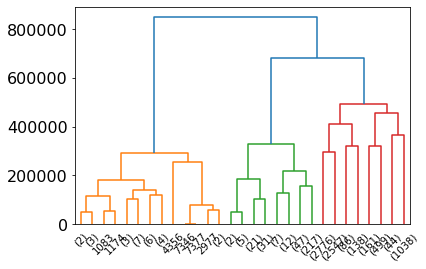

In [34]:
m = 2
expr = expr_date[m]
D = pickle.load(open(os.path.join(r'F:\vae_jy\10July','D_skl_'+expr_date[m]+'.p'),'rb'))
start_idx=cell_date_ind[m]
end_idx=cell_date_ind[m+1]

clustering = AgglomerativeClustering(n_clusters=None,distance_threshold=0,linkage='complete',affinity ='precomputed').fit(D)
plot_dendrogram(clustering,truncate_mode='level',p=4)                  



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

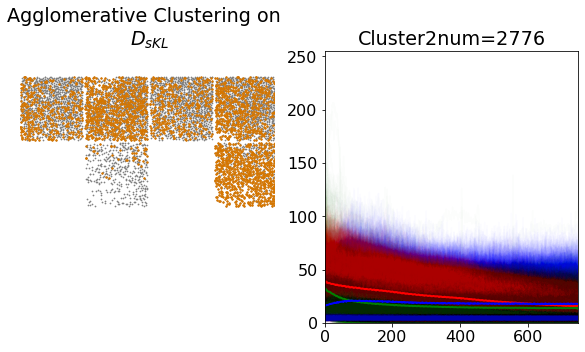

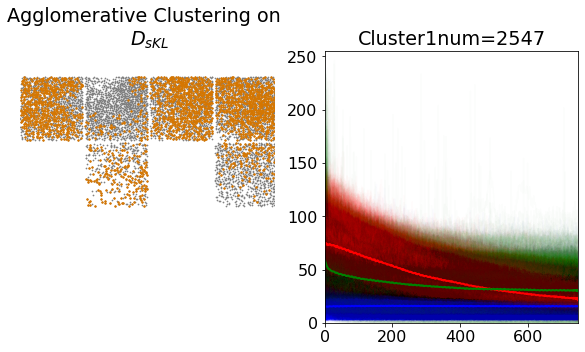

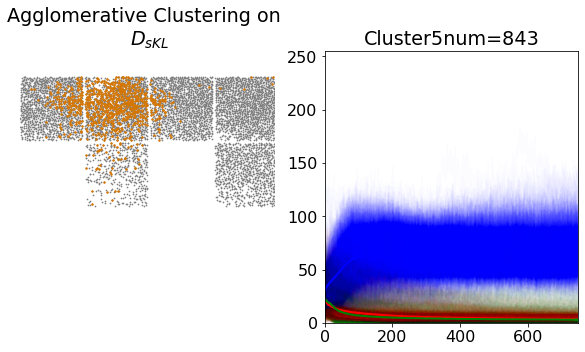

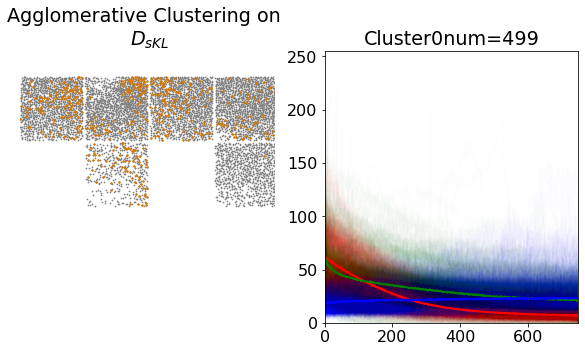

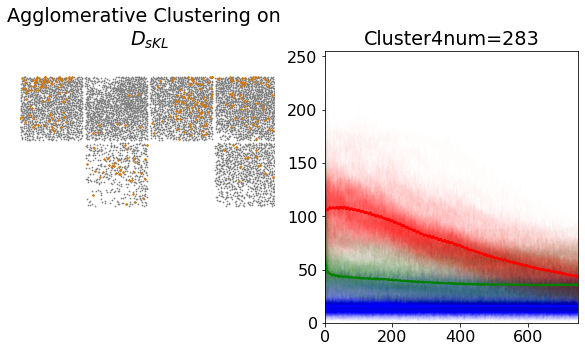

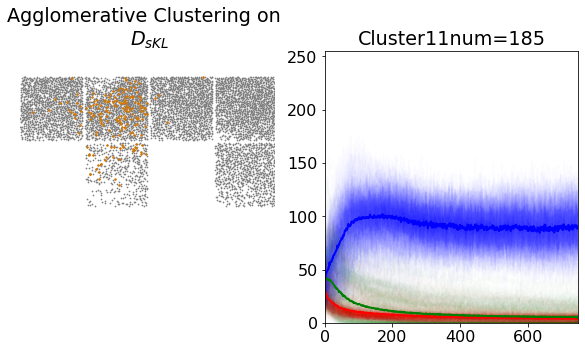

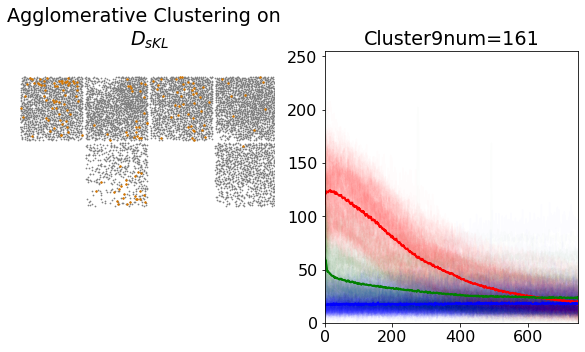

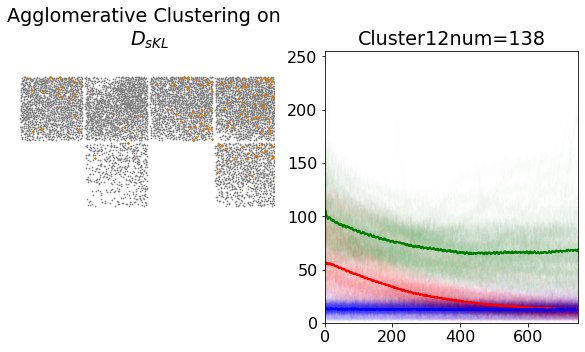

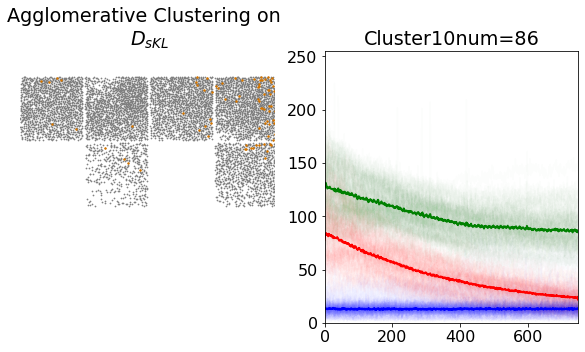

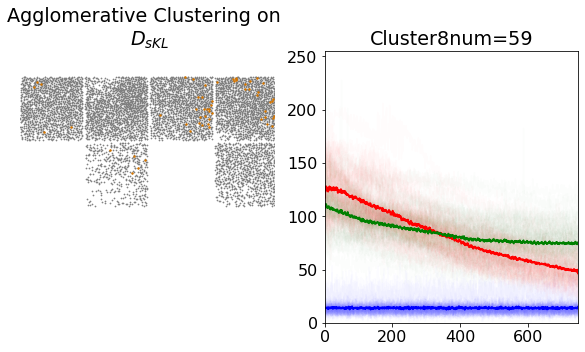

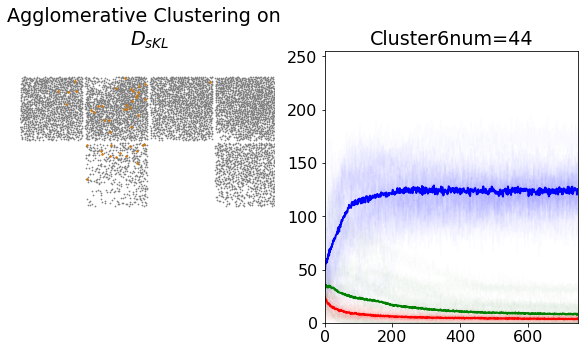

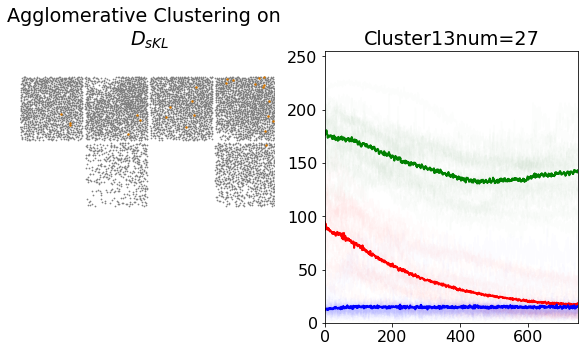

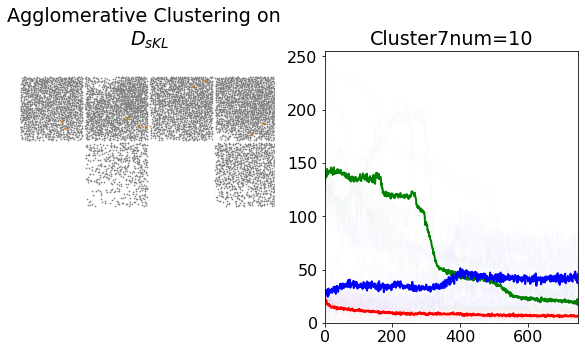

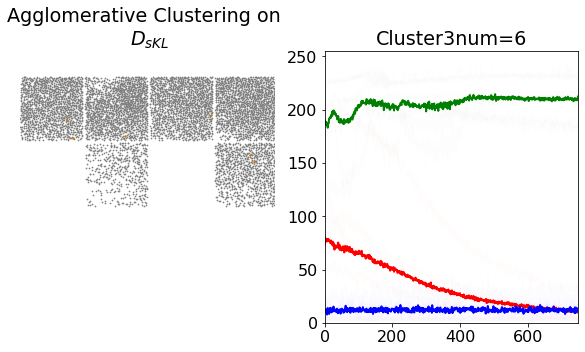

In [39]:

clustering = AgglomerativeClustering(n_clusters = 14,distance_threshold=None,linkage='complete',affinity ='precomputed').fit(D)
# reorder indices 
num_cell_in_cluster = [-sum(clustering.labels_==i) for i in range(clustering.n_clusters_)]
sort_ind = np.argsort(num_cell_in_cluster)

cluster_indices = {}

for count,cluster_ in enumerate(sort_ind):
    cluster_ind=list(np.where(clustering.labels_==cluster_))[0]

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.scatter(loc_x[expr],max(loc_y[expr])-loc_y[expr],c='gray',s=.5)
    ind=np.where(clustering.labels_==cluster_)[0]
    cluster_indices['ncluster_'+str(count)] = ind
    plt.scatter(loc_x[expr][ind],max(loc_y[expr])-loc_y[expr][ind],c=[214/255,118/255,0/255],s=2)
    plt.title('Agglomerative Clustering on \n $D_{sKL}$ ')
    plt.axis([-500,1500,-900,1200])
    plt.axis('off')

    plt.subplot(1,2,2)
    for i in cluster_ind:
        plt.plot(cell_all[start_idx+i,0,:],'r',alpha=0.01)
        plt.plot(cell_all[start_idx+i,1,:],'g',alpha=0.01)
        plt.plot(cell_all[start_idx+i,2,:],'b',alpha=0.01)

    plt.title('Cluster'+str(cluster_)+'num='+str(len(cluster_ind)))
    plt.plot(torch.mean(cell_all[start_idx+cluster_ind,0,:],0),'r-',linewidth=2)
    plt.plot(torch.mean(cell_all[start_idx+cluster_ind,1,:],0),'g-',linewidth=2)
    plt.plot(torch.mean(cell_all[start_idx+cluster_ind,2,:],0),'b-',linewidth=2)
    plt.axis([0,750,0,255])
